## Create Initial states

**Note:** In this implementation, we use a **Normal degradation model** as a
concrete example. However, this choice is not restrictive. Any custom
**stochastic degradation model** can be implemented by subclassing the
`DegModel` abstract base class and providing the required interface.

In [ ]:
import numpy as np
from pathlib import Path
import os
import pandas as pd
import torch

import matplotlib.pyplot as plt
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping

from src.models.degradation_models.normal import NormalDegradationModel as NModel, NormalDegradationNLL as NLoss
from src.pipelines.init_states import PlotNormalDistWithData,BestModelTracker
from src.helpers.seed import set_global_seed

In [20]:
data_name = "DS05"
SEED = 42

set_global_seed(SEED)
experiment_dir = Path('experiments')/data_name
states_dir = experiment_dir/'states'
os.makedirs(states_dir, exist_ok=True)

## Import training data


In [21]:
hi_df = pd.read_csv(experiment_dir/'hidata_dev.csv')
units = hi_df['unit'].astype(int).unique().tolist()
units 

[1, 2, 3, 4, 5, 6]

### Extract degradation onset

In [22]:
onsets = {unit: hi_df[(hi_df['unit']==unit) & (hi_df['hs']==0)]['cycle'].values[0] for unit in units}
del hi_df['hs']

In [23]:
perform_names = [col for col in hi_df.columns if col not in ['unit','cycle']]

performs = {name: 
    {unit: hi_df[hi_df['unit']==unit][name].values for unit in units} 
    for name in perform_names
}
time = {unit: hi_df[hi_df['unit']==unit]['cycle'].values for unit in units}

## Model initialization

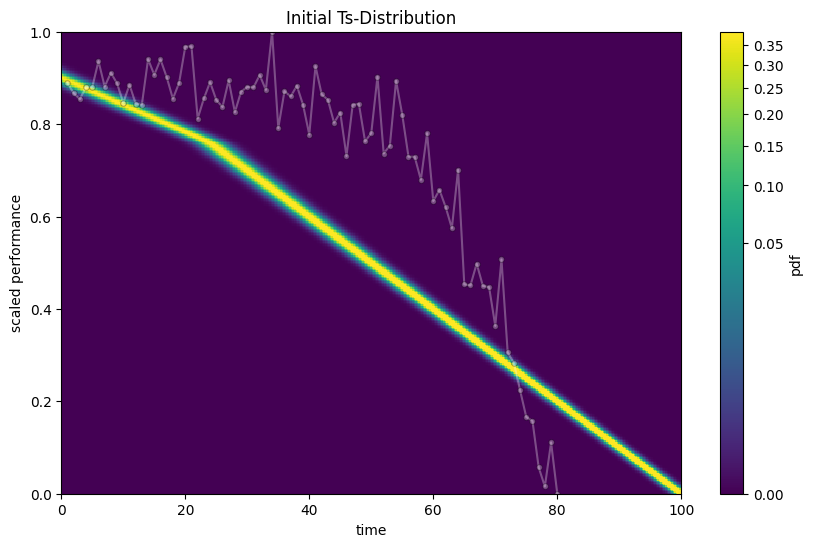

In [24]:
s_np:np.ndarray = performs['SmLPC'][1]
t_np:np.ndarray = time[1]
onset = onsets[1] 

# grids
t = np.linspace(0.1, 100, 400)  # Start from 0.1 instead of 0.0 (LogNormal support is t > 0)
s = np.linspace(0.0, 1.0, 300)

model = NModel(onset=onset)

ax = model.plot_distribution(
    t=t,
    s=s,
    func="pdf",
    title="Initial Ts-Distribution",
)

ax.plot(t_np,s_np,'o-',
		color='white',alpha=0.3,markersize=4,markeredgecolor='black',markeredgewidth=0.8,
  		label='data')
plt.show()

## Create Initial Particles (Training)
The number of (pure) particles $N$ is the the number of training trajectories.

## Callbacks

In [25]:
early_stop_cb = EarlyStopping(
	monitor="train_loss",
	patience=500,
	threshold=1e-5,
	threshold_mode="rel",
	lower_is_better=True,
)

besttracker_cb=BestModelTracker(
	monitor  = "train_loss",
	min_delta = 0.01,
	save_dir = ".", # to be set later
	f_params = "best_model.pt",
	load_best = True,  
)

plot_cb = PlotNormalDistWithData(
	t_grid=t,
	s_grid=s,
	time_data=None,   # to be set later           
	perform_data=None, # to be set later          
	plot_every=None, #
	func="pdf",
	title=None,
	plot_at_end = True,
	show=False, #
	save_dir= None,   # to be set later             
)
    

## Regressor

In [26]:
net = NeuralNetRegressor(
            module=NModel,
            module__onset=None,  # to be set later
            criterion=NLoss,
            optimizer=torch.optim.Adam,
            lr=1e-2,
            max_epochs=100_000, #
            batch_size=-1,
            train_split=None,
            verbose=0,
            callbacks=[besttracker_cb,early_stop_cb, plot_cb],
        )

## Train

In [27]:
for perform_name, units_perform in performs.items():
    print(f"\nTraining performance: {perform_name}")
    for unit, perform in units_perform.items():
        print(f"  Unit {unit}/{len(units_perform)}", end=" ", flush=True)

        # Prepare data for training 
        t_np: np.ndarray = time[unit]
        s_np: np.ndarray = perform

        X = s_np.astype(np.float32).reshape(-1, 1)
        y = t_np.astype(np.float32).reshape(-1, 1)
        
        # update callbacks with unit-specific info
        unit_dir = states_dir / perform_name / f"unit_{unit}"
        besttracker_cb.save_dir = unit_dir
        plot_cb.save_dir = unit_dir
        plot_cb.title = f"Normal SP for perform {perform_name} Unit {unit}"
        plot_cb.time_data = t_np
        plot_cb.perform_data = s_np
        if (data_name == "DS05") & (perform_name == 'SmHPC') & (unit == 1):
            net.set_params(module__onset=t_np[-1])
        else:
            net.set_params(module__onset=onsets[unit])
        net.initialize()
        net.fit(X, y)

        print("Done")

print("initial states training completed.")


Training performance: SmHPC
  Unit 1/6 Done
initial states training completed.
